In [3]:
import operator
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import wrappers

#Cross-Entropy
np.random.seed(0)
d = 376
bins = 17

ds = [d, 256, bins]
dim = 0
for i in range(len(ds)-1):
    dim += (ds[i]+1)*(ds[i+1])

print(dim)

curr_mean = 0
curr_std = 0.1
it = 0
        
def policy_cem(obs):
    out = obs.reshape(1, d)
    W = Ws[it]
    
    ind = 0
    for i in range(len(ds)-1):
        out = out.reshape(1, -1)
        
        d1 = ds[i]
        d2 = ds[i+1]
        w = W[ind:ind+d1*d2].reshape(d1, d2)
        ind = ind+d1*d2
        b = W[ind:ind+d2]
        ind = ind + d2
        out = out.dot(w) + b
        if ind != len(W):
            out = np.tanh(out)
    
    return np.tanh(out)*0.4
    
env = gym.make('Humanoid-v1')
#env = wrappers.Monitor(env, '/tmp/mountaincar-experiment-1',force=True)
scores = []
std = []
mean = []
alpha = 1
N = 100
P = int(N/5)

for i in range(100):
    
    Ws = (np.random.randn(N, dim))*curr_std + curr_mean
    b = {}
    for j in range(N):
        
        it = j
        sc, r = play(1, 1000000, policy_cem)
        b[j] = -r
    
    scores.append(np.mean([-v for i, v in b.items()]))
    sorted_b = sorted(b.items(), key=operator.itemgetter(1))
    
    print(scores[-1])
    
    idx = [k for k, v in sorted_b[:P]]
    v = np.array([v for k, v in sorted_b[:P]]).reshape(-1, 1)
    
    curr_mean = curr_mean*(1-alpha) + alpha*np.sum(Ws[idx]*v, axis=0)/np.sum(v)
    curr_std = curr_std*(1-alpha) + alpha*np.sqrt(np.sum(v*(Ws[idx]-curr_mean)**2, axis=0)/np.sum(v)) #+ np.max(10-i/100, 0)
    
    if np.sqrt(np.sum(curr_std**2)) < 1e-3:
        break
    
    std.append(curr_std[0])
    mean.append(curr_mean[0])

env.close()

#plt.plot(std)
#plt.plot(mean)
plt.plot(scores)
plt.show()


[2017-05-21 21:43:13,954] Making new env: Humanoid-v1


100881
122.591174963
117.671090207
114.014837953
120.781004282


KeyboardInterrupt: 

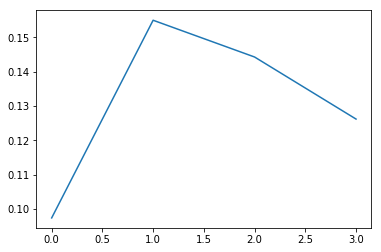

In [4]:
plt.plot(std)
plt.show()
env.close()

[2017-05-06 12:22:59,498] Making new env: Pendulum-v0


[-2.86649597]


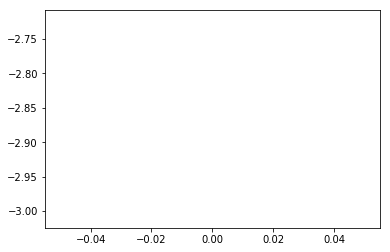

In [370]:
import operator
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import wrappers
from scipy import stats
from scipy.stats import truncnorm
from scipy.special import expit

#policy gradient

ds = [3, 50, 10, 2]
dim = 0
for i in range(len(ds)-1):
    dim += (ds[i]+1)*(ds[i+1])

discount = 0.99
lr = 1e-3
W = np.random.randn(1, dim)[0]*0.1
x1 = -2
x2 = +2
cache = []

def compute_normals(obs):
    out = obs.reshape(1, 3)
    global cache
    cache = []
    cache.append(out)
    ind = 0
    for i in range(len(ds)-1):
        out = out.reshape(1, -1)
        
        d1 = ds[i]
        d2 = ds[i+1]
        w = W[ind:ind+d1*d2].reshape(d1, d2)
        ind = ind+d1*d2
        b = W[ind:ind+d2]
        ind = ind + d2
        out = out.dot(w) + b
        
        cache.append(out)
        
        if ind != len(W):
            out = expit(out)
    
    out = out[0]
    mean, variance = 2*np.tanh(out[0]), 2*expit(out[1])
    return mean, variance

def policy(obs):
    mean, variance = compute_normals(obs)
    
    if variance < 1e-20:
        #if np.random.rand() < 0.001:
        #    print(mean, variance)
        
        a = mean
    else:
        #if np.random.rand() < 0.001:
        #    print(variance, mean)
        
        a = truncnorm.rvs((x1-mean)/np.abs(variance), (x2-mean)/np.abs(variance), loc=mean, scale=np.abs(variance))
    #a = np.random.randn()*np.abs(variance) + mean
    #print(a)
    return [a]
    
def truncnorm_dx(a, m, v):
    
    if v < 1e-20:
        dm, dv = 0, 0
    else:
        eps = min(1e-5, np.abs(m)*1e-4)

        p1 = truncnorm.pdf(a, (x1-(m-eps))/np.abs(v), (x2-(m-eps))/np.abs(v), loc=m-eps, scale=np.abs(v))
        p2 = truncnorm.pdf(a, (x1-(m+eps))/np.abs(v), (x2-(m+eps))/np.abs(v), loc=m+eps, scale=np.abs(v))

        dm = (np.log(p2)-np.log(p1))/(2*eps)

        eps = min(1e-5, np.abs(v)*1e-4)

        p1 = truncnorm.pdf(a, (x1-m)/(np.abs(v)-eps), (x2-m)/(np.abs(v)-eps), loc=m, scale=np.abs(v)-eps)
        p2 = truncnorm.pdf(a, (x1-m)/(np.abs(v)+eps), (x2-m)/(np.abs(v)+eps), loc=m, scale=np.abs(v)+eps)
        dv = (np.log(p2)-np.log(p1))/(2*eps)
        dv *= np.abs(v)/v
    
    return dm, dv
    
def compute_gradients(actions, net, states):
    grads = np.zeros(*W.shape)
    for a, r, s in zip(actions, net, states[:-1]):
        mean, variance = compute_normals(s)
        #dm, dv = (a-mean)/(variance**2), (((a-mean)**2)*variance**-3 - variance**-1)*np.abs(variance)/variance
        
        dm, dv = truncnorm_dx(a, mean, variance)
        
        #tan, sigmoid grad
        t1 = cache[-1][0][0]
        t2 = cache[-1][0][1]
        
        dm *= 2*4*expit(2*t1)*(1-expit(2*t1))
        dv *= 2*expit(t2)*(1-expit(t2))
        
        dx = np.array([dm, dv])
        
        ind = 0
        for i in range(len(ds), 1, -1):
            
            d1 = ds[i-2]
            d2 = ds[i-1]
            
            dx = dx.reshape(d2, 1)
            
            xn = cache[i-2]
                        
            if i > 2:
                x = expit(xn)
            else:
                x = xn
            
            if ind == 0:
                i1 = ind-d2
                i2 = 0
                b = W[ind-d2:]
            else:
                i1 = ind-d2
                i2 = ind
                b = W[ind-d2:ind]
            
            ind = ind-d2
            
            i3 = ind-d1*d2
            i4 = ind
            w = W[i3:i4].reshape(d1, d2)
            
            ind = i3
            
            #print(i, x.shape, w.shape, b.shape, dx.shape, d1, d2, r)
            
            grads[i3:i4] += ((x.reshape(d1, 1)).dot(dx.T)*r).reshape(grads[i3:i4].shape)
            dxn = w.dot(dx)
            
            if i2 != 0:
                grads[i1:i2] += dx.reshape(grads[i1:i2].shape)*r
            else:
                grads[i1:] += dx.reshape(grads[i1:].shape)*r
            
            dx = dxn
            dx = dx*(x.T*(1-x.T))
            
    return grads

def numeric_gradient(actions, net, states):
    grads = np.zeros(*W.shape)
    eps = 1e-5
    
    for a, r, s in zip(actions, net, states[:-1]):
        for idx in range(len(W)):
            W[idx] = W[idx] - eps
            mean, variance = compute_normals(s)
            p1 = truncnorm.pdf(a, (x1-mean)/np.abs(variance), (x2-mean)/np.abs(variance), loc=mean, scale=np.abs(variance))
            
            W[idx] = W[idx] + 2*eps
            mean, variance = compute_normals(s)
            p2 = truncnorm.pdf(a, (x1-mean)/np.abs(variance), (x2-mean)/np.abs(variance), loc=mean, scale=np.abs(variance))
            
            W[idx] -= eps
            grads[idx] += r*(np.log(p2)-np.log(p1))/(2*eps)
            
    return grads

def update(actions, states, rewards):
    
    for i in range(len(rewards), 0, -1):
        if i == len(rewards):
            net = [rewards[-1]]
        else:
            net = [rewards[i-1] + discount*net[-1]] + net
    
    grads1 = compute_gradients(actions, net, states)
    #grads2 = numeric_gradient(actions, net, states)
    
    #print(grads1)
    #print(grads2)
    #print("grad", np.sqrt(np.sum((grads1-grads2)**2)))
    
    global W, lr
    
    W += lr*grads1

env = gym.make("Pendulum-v0")

T = 1
rewards = []
lr = 1e-2
discount = 0.99
for i in range(T):
    _, r = play(1, 1, policy, update)
    
    rewards.append(r)
    
    if i %10 == 0:
        print(r)

env.close()

plt.plot(rewards)
plt.show()


In [3]:

def downsample(image):
    # Take only alternate pixels - basically halves the resolution of the image (which is fine for us)
    return image[::2, ::2, :]

def remove_color(image):
    """Convert all color (RGB is the third dimension in the image)"""
    return image[:, :, 0]

def remove_background(image):
    image[image == 144] = 0
    image[image == 109] = 0
    return image

def preprocess_observations(input_observation):
    """ convert the 210x160x3 uint8 frame into a 6400 float vector """
    processed_observation = input_observation[35:195] # crop
    processed_observation = downsample(processed_observation)
    processed_observation = remove_color(processed_observation)
    processed_observation = remove_background(processed_observation)
    processed_observation[processed_observation != 0] = 1 # everything else (paddles, ball) just set to 1
    
    return processed_observation.reshape(80, 80, 1)

def generate_observation(observation1, observation2, observation3, observation4):
    return np.dstack((observation1, observation2, observation3, observation4))


In [13]:
from collections import deque
import random
import numpy as np
from scipy.special import expit
from scipy.stats import truncnorm

# correct solution:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

#Evolutionary strategies
d = 8
bins = 2
ds = [d, 256, bins]
dim = 0
for i in range(len(ds)-1):
    dim += (ds[i]+1)*(ds[i+1])

obs1 = None
    
def policy_ev(obs):
    
    #global obs1
    
    #if obs1 is None:
    #    obs1 = preprocess_observations(obs)
    #    return 0
    #else:
    #    obs2 = preprocess_observations(obs)
    #    obs = obs2-obs1
    #    obs1 = obs2
        
    out = obs.reshape(1, d)
    
    ind = 0
    for i in range(len(ds)-1):
        out = out.reshape(1, -1)
        
        d1 = ds[i]
        d2 = ds[i+1]
        w = W[ind:ind+d1*d2].reshape(d1, d2)
        #w = w/np.sqrt(np.sum(w*w))
        ind = ind+d1*d2
        b = W[ind:ind+d2]
        #b = b/np.sqrt(np.sum(b*b))
        ind = ind + d2
        out = out.dot(w) + b
        if ind != len(W):
            out = np.maximum(out, 0)
    
    a = np.clip(out[0], -1, 1) 
    #np.argmax(out)+2
    #print(a)
    return a #np.argmax(out[0])

nparticles = 100
print("Initializing Weights...")
Wx = np.random.randn(nparticles, dim) *0.1
print("Weights Initialized")
print()

env = gym.make("Swimmer-v1")
#env = wrappers.Monitor(env, '/tmp/mountaincar-experiment-1',force=True)

#npop = 1000
it = 10000
std = 1e-2
t = 1
dec = 0.999
alpha = 1
numest = 1
T = 500

K = np.zeros(nparticles)
R = np.zeros(nparticles*numest)

for i in range(it):
    
    for j in range(nparticles):
        W = Wx[j]
        obs1 = None
        K[j] = 0
        
        for k in range(numest):
            _, r = play(1, T, policy_ev)
            R[j*numest + k] = r
            K[j] += r
            
        #X = R[j*numest:j*numest+numest]
        #print(np.mean(X), np.std(X), np.min(X), np.max(X))
        
    eps = 1e-6
    p = softmax(K*t)
    Wz = np.zeros((nparticles, dim))
    
    s = np.random.choice(nparticles, size=nparticles, replace=True, p=p)
    for j in range(nparticles):
        Wz[j] = Wx[s[j]]
    
    Wx = Wz
    
    N = (np.random.randn(nparticles, dim)*std) #*(1-p).reshape(-1,1)
    Wx += N
    #t *= dec
    print("Episode finished", np.mean(R), np.std(R), np.min(R), np.max(R))
    
env.close()


[2017-06-02 21:44:42,148] Making new env: Swimmer-v1


Initializing Weights...
Weights Initialized

Episode finished -3.56822961646 17.7664765912 -28.5695732393 34.5023773987
Episode finished 28.0094520046 10.0616363735 -3.28727683876 39.5242434488
Episode finished 27.7408179908 14.0020473349 -25.3864557597 39.2842754707
Episode finished 27.5272893128 14.49414016 -19.8399841661 40.4056518931
Episode finished 28.450622904 13.552685065 -21.7517540496 40.7830463614
Episode finished 28.8616673692 13.7621094685 -24.0969935973 41.0972931627
Episode finished 30.2426441876 10.5730417428 1.43546277001 40.6887431923
Episode finished 27.823175129 13.3510259889 -20.0342892057 43.0274876555
Episode finished 23.8392456348 16.1555468833 -21.2785474694 42.3485461333
Episode finished 26.0666874318 14.7209997372 -16.35434779 42.0281302158


KeyboardInterrupt: 

In [6]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from lib.VanillaPolicyGradient import *
import matplotlib.pyplot as plt

env = gym.make("Pong-v0")
#env = wrappers.Monitor(env, '/tmp/acrobot-v1',force=True)

d = 6
bins = 2
num_obs = 2
input_shape = (None, num_obs, 80, 80, 1)
layers = ['flatten', 'fc', (None, 256)]
lr = 1e-4
discount = 0.99
T = 5000

#vpg = VanillaPG(input_shape, layers, num_actions=bins, learning_rate=lr)
plot_rews = []

avg_rew = 0
alpha = 0.9
batch_size = 32

def update(actions, states, rewards):
    
    acc_rew = []
    n = len(rewards)
    
    acc_rew.append(rewards[-1])
    for i in range(n-1):
        acc_rew = [discount*acc_rew[0] + rewards[n-i-1]] + acc_rew
    
    for i in range(n):
        acc_rew[i] -= acc_rew[i]/(n-i)
    
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions)
    advantages = np.array(acc_rew)
    
    split_states = np.array_split(states, batch_size)
    split_actions = np.array_split(actions, batch_size)
    split_advantages = np.array_split(advantages, batch_size)
    for st, ac, ad in zip(split_states, split_actions, split_advantages):
        vpg.update(st, ac, ad)
    
    plot_rews.append(np.sum(rewards))
    
    global avg_rew
    avg_rew = alpha*avg_rew + (1-alpha)*np.sum(rewards)
    
    if len(plot_rews) % 20 == 0:
        print(avg_rew, np.sum(rewards))
    
    if len(plot_rews)%100 == 0:
        plt.clf()
        plt.plot(plot_rews)
        plt.show()
    
def policy(obs):
    return vpg.choose_action(obs)[0]+2

play(1000000, T, policy, update, preprocess=preprocess_observations, num_obs=num_obs)

NameError: name 'gym' is not defined

In [12]:
import gym
from gym import wrappers
import matplotlib.pyplot as plt

def play(num_episodes, num_steps, policy, update=None, preprocess = None, num_obs=1):
    time_steps = []
    for i_episode in range(num_episodes):
        observation = env.reset()
        states, actions, rewards = [], [], []
        observations = []
        r = 0
        for t in range(num_steps):
            #env.render()
            #observation = np.concatenate((np.array([observation[0]]),observation[1]))
            
            states.append(observation)
            
            if len(states) < num_obs:
                action = env.action_space.sample()
            else:
                obs = states[-num_obs:]
                
                if preprocess is not None:
                    for i in range(num_obs):
                        obs[i] = preprocess(obs[i])
                
                observations.append(np.array(obs))
                action = policy(np.array(obs))

            observation, reward, done, info = env.step(action)
            r += reward
            
            actions.append(action)
            rewards.append(reward)
                
            if done:
                break
        
        if update:
            update(actions[num_obs-1:], observations, rewards[num_obs-1:])
        
        time_steps.append(t)

    #env.close()
    #w, b = best_params
    return time_steps, r

In [1]:
import gym
from gym import wrappers

gym.upload('/tmp/mountaincar-experiment-1', api_key='sk_aJYIMFATbWMBRlWoleTQ')

[2017-05-30 18:43:30,113] Training directory /tmp/mountaincar-experiment-1 not found
[2017-05-30 18:43:30,195] An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 238))



Error: Could not find any manifest files in /tmp/mountaincar-experiment-1.

(HINT: this usually means you did not yet close() your env.monitor and have not yet exited the process. You should call 'env.monitor.start(training_dir)' at the start of training and 'env.monitor.close()' at the end, or exit the process.)

In [242]:
for i in range(10000):
    x = (np.random.randn()*0.2)
    if x > 1 or x < -1:
        print(x)

In [260]:
m=1
v=2
x1 = -2
x2 = +2

truncnorm.rvs((x1-m)/v, (x2-m)/v, loc=m, scale=v)

0.60728585378441924

In [8]:
import gym
env = gym.make("AirRaid-ram-v0")
env.action_space.sample()

[2017-05-28 17:15:43,644] Making new env: AirRaid-ram-v0


4

In [16]:
x = [1, 2, 3, 4]
x[0:]

[1, 2, 3, 4]